## ENSF611 Project
**Authors: Tobin Eberle, Tom Wilson, Jeff Wheeler**

### Project Outline

Avalanche forecasting is the practice of observing current and historical snowpack conditions to make educated guesses about how reactive the snowpack is, and thus the likelihood of avalanches. It is a mixture of an art and a science where field observations and a forecaster's experience generally have a lot of weight in the final avalanche rating for a particular area. This project will investigate the classification of avalanche ratings for each of the three avalanche zones in Yoho National Park (Canada), to determine how accurately we can determine the likelihood of avalanches solely based on weather data.

For reference the avalanche danger ratings are as follows:
- No Rating: Summer, or no snow in the mountains.
- Spring Conditions: Very variable avalanche conditions based on the fluctuation of temperature throughout the day making it difficult to forecast.
- Low: Generally safe avalanche conditions.
- Moderate: Heightened avalanche conditions.
- Considerable: Dangerous avalanche conditions.
- High: Very dangerous avalanche conditions.
- Exterme: Extraordinarily dangerous avalanche conditions.

The avalanche zones are split into three seperate areas:
- Below Treeline (btl): Elevation of a mountain band that is covered by forest.
- Treeline (tln): Sparse forest cover and is the transition between uniform forest cover below it and the alpine above it.
- Alpine (alp): Wide expanses of open, exposed terrain with few or no trees.

It is important to note there is a  difference between the avalanche zones as they each obtain a seperate rating from eachother.

### Pre-Processing
Pre-process the data to remove NaN's and fill missing data.

In [37]:
#ignoring some deprication warnings
import warnings
warnings.filterwarnings('ignore') 

#Import the dataset and inspect the contents
import pandas as pd
df = pd.read_csv('av_dataset_ensf611.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     2140 non-null   object 
 1   btl_rating               2140 non-null   object 
 2   tln_rating               2140 non-null   object 
 3   alp_rating               2140 non-null   object 
 4   problem_1                880 non-null    object 
 5   problem_2                565 non-null    object 
 6   problem_3                157 non-null    object 
 7   chance_1                 880 non-null    object 
 8   chance_2                 565 non-null    object 
 9   chance_3                 157 non-null    object 
 10  longitude                2140 non-null   float64
 11  latitude                 2140 non-null   float64
 12  station_name             2140 non-null   object 
 13  climate_id               2140 non-null   object 
 14  year                    

The strategy to deal with missing values in the following columns is as follows:

```date```: Drop first date column as it contains redundant information.

```btl/tln/alp_rating```: Delete NaN rows.

```problem_1/2/3```: Replace NaN with 'noproblem'. Format column to ensure no '-' seperates the problem description.

```chance_1/2/3```: Drop these columns as they are determined by forecasters and will skew results.

```longitude/latitude/climate_id/data_quality/station_name```: Drop columns as not relevant to dataset.

```year/month/day```: No missing values

```max/min/mean_temp```: Forward fill (extreme of temps should be relatively simlar day-to-day)

```hot/cool_deg_days```: Forward fill. Otherwise could drop these columns as they are a derivation of temperature extremes.

```total_rain/snow```: Drop columns as all null.

```total_precip```: Fill Nan with zeros as can assume no precipitaion.    

```snow_on_ground```: Forward fill as the snow remains monstly constant for missing data points

```dir_of_max_gust```: Drop as wind direction isn't as important as wind speed and wind directions of winds under 27km/h aren't recorded.

```spd_of_max_gust```: Fill with zeroes, this is only reported if wind is greated than 31km/h. 


In [38]:
#Implement the data cleaning for each column as outlined above
import re
pattern = r'[^\w]'

#Dropping unneeded columns
df = df.drop(columns= ['date', 'chance_1', 'chance_2', 'chance_3', 'longitude', 'latitude', 'climate_id', 'station_name', 'data_quality', 'total_rain_mm', 'total_snow_cm', 'dir_of_max_gust_10s_deg'])

#First 325 rows are missing avalanche rating data, drop them
df.drop(axis = 0, inplace= True, index= range(0, 325))

#Avalanche problems
df['problem_1'].fillna('noproblem', inplace= True)
df['problem_2'].fillna('noproblem', inplace= True)
df['problem_3'].fillna('noproblem', inplace= True)
df['problem_1'] = df['problem_1'].replace(pattern, '', regex= True)
df['problem_2'] = df['problem_2'].replace(pattern, '', regex= True)
df['problem_3'] = df['problem_3'].replace(pattern, '', regex= True)

#Temperatures
df['max_temp_c'].ffill(inplace= True)
df['min_temp_c'].ffill(inplace= True)
df['mean_temp_c'].ffill(inplace= True)
df['cool_deg_day_c'].ffill(inplace= True)
df['heat_deg_day_c'].ffill(inplace= True)

#Precipitation
df['total_precip_mm'].fillna(0, inplace= True)
df['snow_on_ground_cm'].ffill(inplace= True)

#Wind Speed
df['spd_of_max_gust_kmh'].fillna(0, inplace= True)

#Dropping of summer months
df = df[df.month != 5]
df = df[df.month != 6]
df = df[df.month != 7]
df = df[df.month != 8]
df = df[df.month != 9]
df = df[df.month != 10]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896 entries, 325 to 2139
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   btl_rating           896 non-null    object 
 1   tln_rating           896 non-null    object 
 2   alp_rating           896 non-null    object 
 3   problem_1            896 non-null    object 
 4   problem_2            896 non-null    object 
 5   problem_3            896 non-null    object 
 6   year                 896 non-null    int64  
 7   month                896 non-null    int64  
 8   day                  896 non-null    int64  
 9   max_temp_c           896 non-null    float64
 10  min_temp_c           896 non-null    float64
 11  mean_temp_c          896 non-null    float64
 12  heat_deg_day_c       896 non-null    float64
 13  cool_deg_day_c       896 non-null    float64
 14  total_precip_mm      896 non-null    float64
 15  snow_on_ground_cm    896 non-null    float

Our dataset now contains 1815 non-null rows. Inspecting the head of the data shows the new format.

In [39]:
#Preview the data
df.head()

,btl_rating,tln_rating,alp_rating,problem_1,problem_2,problem_3,year,month,day,max_temp_c,min_temp_c,mean_temp_c,heat_deg_day_c,cool_deg_day_c,total_precip_mm,snow_on_ground_cm,spd_of_max_gust_kmh
325,low,low,low,noproblem,noproblem,noproblem,2019,11,22,-8.6,-11.1,-9.8,27.8,0.0,0.0,43.0,58.0
326,low,low,low,stormslab,noproblem,noproblem,2019,11,23,-3.5,-8.9,-6.2,24.2,0.0,0.0,44.0,48.0
327,low,low,moderate,windslab,noproblem,noproblem,2019,11,24,-1.3,-6.2,-3.8,21.8,0.0,0.0,57.0,55.0
328,low,low,moderate,windslab,noproblem,noproblem,2019,11,25,-5.3,-13.0,-9.2,27.2,0.0,0.0,54.0,0.0
329,low,low,moderate,windslab,noproblem,noproblem,2019,11,26,-9.1,-19.8,-14.5,32.5,0.0,0.0,52.0,0.0


### Data split
With the pipline in place, we can split the data in target vectors and feature matrix. For this project we will be investingating the ratings for three different areas, thus we will have three target vectors. Each of these target vectors will be trained individually and then compared.

In [40]:
from sklearn.model_selection import train_test_split

#Create target vectors and feature matrix
X = df.drop(columns=['btl_rating', 'tln_rating', 'alp_rating'])
y_btl = df['btl_rating']
y_tln = df['tln_rating']
y_alp = df['alp_rating']

print('Feature matrix shape: ', X.shape)
print('Target y_btl shape: ', y_btl.shape)
print('Target y_tln shape: ', y_tln.shape)
print('Target y_alp shape: ', y_alp.shape)

Feature matrix shape:  (896, 14)
Target y_btl shape:  (896,)
Target y_tln shape:  (896,)
Target y_alp shape:  (896,)


### Pipeline

Creating a column transformer and pipeline will allow us to encode and normalize our dataset. Note, target vectors do not need to be encoded for sklearn classifiers so the rating columns can remain strings. Here we create a few options for our analysis:

```configureParams(long, one_hot_columns)``` lets us choose if we want to use a long or short list of parameters (long takes about ~9 minutes to run, short takes ~2 minutes), and whether we include the ```problem``` columns from the dataset. The problems columns are field observations from avalanche forecasters, so by exluding these features we are testing how accurate our models are using ONLY weather data. 

In [41]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import set_config
import numpy as np


#Function for configuring how we conduct the analysis
def configureParams(long, one_hot_columns):
    ct1 = ColumnTransformer(transformers=[('scaling', StandardScaler(), make_column_selector(dtype_include= float)),
                            ('onehotencoding', OneHotEncoder(sparse_output= True, handle_unknown='ignore'), one_hot_columns)
                            ])
    ct2 = ColumnTransformer(transformers=[('scaling', RobustScaler(), make_column_selector(dtype_include= float)),
                            ('onehotencoding', OneHotEncoder(sparse_output= True, handle_unknown='ignore'), one_hot_columns)
                            ])
    
    #Longer list of parameters
    param_grid_long = [
        {
            'preprocessor': [ct1, ct2],
            'classifier': [LogisticRegression(random_state=0)]
            ,
            'classifier__max_iter': [1000, 2000, 3000],
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__fit_intercept': [True, False]
        }
        ,
        {
            'preprocessor': [ct1, ct2],
            'classifier': [RandomForestClassifier(random_state=0)]
            ,
            'classifier__n_estimators': [400, 800, 1200],
            'classifier__max_depth': [11, 13, 15]
        }
        ,
        {
            'preprocessor': [ct1, ct2],
            'classifier': [MLPClassifier(random_state=0)]
            ,
            'classifier__hidden_layer_sizes': [50, 100, 200],
            'classifier__solver': ['adam', 'sgd', 'lbfgs']
        }
        ,
        {
            'preprocessor': [ct1, ct2],
            'classifier': [SVC(random_state=0)]
            ,
            'classifier__C': [0.1, 1.0, 10.0, 100.0, 1000.0]
        }
        ,

    ]

    #Shorter list of parameters
    param_grid_short = [
    {
        'preprocessor': [ct1],
        'classifier': [LogisticRegression(random_state=0)],
        'classifier__max_iter': [2000],
        'classifier__C': [0.001],
        'classifier__fit_intercept': [True]
    }
    ,
    {
        'preprocessor': [ct1],
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': [50],
        'classifier__max_depth': [5]
    }
    ,
    {
        'preprocessor': [ct1],
        'classifier': [MLPClassifier(random_state=0)],
        'classifier__hidden_layer_sizes': [25],
        'classifier__solver': ['adam']
    }
    ,
    {
        'preprocessor': [ct1],
        'classifier': [SVC(random_state=0)],
        'classifier__C': [0.01]

    }
    ,

]
    return param_grid_long if long else param_grid_short

#Function for creating a pipeline
def configurePipeline(long, include_problem_fields, one_hot_columns):
    
    #Create column transformer.  handle_unknown is one way to deal with the fact that not all problems occur in all problem columns.
    ct1 = ColumnTransformer(transformers=[('scaling', StandardScaler(), make_column_selector(dtype_include= float)),
                            ('onehotencoding', OneHotEncoder(sparse_output= False, handle_unknown='ignore'), one_hot_columns)
                            ])
    ct2 = ColumnTransformer(transformers=[('scaling', RobustScaler(), make_column_selector(dtype_include= float)),
                            ('onehotencoding', OneHotEncoder(sparse_output= False, handle_unknown='ignore'), one_hot_columns)
                            ])

    #Create pipeline
    pipe = Pipeline(steps= [('preprocessor', ct1),
                            ('classifier', LogisticRegression(max_iter=1000))])
    return pipe

### Gridsearch Cross Validation

Perform the gridSearchCV using the pipeline functions defined above. Note, you can tune the parameters under the "Analysis Options" section (default is false, false). 


In [42]:

######################
# ANALYSIS OPTIONS
long = True
include_problem_fields = False
#####################

print("### Options:")
print("Use Long analysis - " + str(long))
print("Include problem fields in analysis - " + str(include_problem_fields))
print("")

#Configuring onehot encoding columns, parameter grid, pipeline, and final X dataframe
one_hot_columns = ['problem_1', 'problem_2', 'problem_3', 'year', 'month', 'day'] if include_problem_fields else ['year', 'month', 'day']
param_grid = configureParams(long, one_hot_columns)
pipe = configurePipeline(long, include_problem_fields, one_hot_columns)
X_final = X if include_problem_fields else X.drop(['problem_1', 'problem_2', 'problem_3'], axis=1)

#Visualize the pipeline
set_config(display='diagram')

#Create feature dictionary
y_dict = {"Below Treeline Without Observed Problems": y_btl, "Treeline Without Observed Problems": y_tln, "Alpine Without Observed Problems": y_alp}

# List to collect results to create a dataframe
results_list = []

#GridSearch function
def performGridSearch(X, y, pipe, param_grid):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
    stratification = StratifiedShuffleSplit(n_splits=5)
    # error_score='raise' will stop the fit if it hits an issue instead of putting nan in results
    grid_search = GridSearchCV(pipe, param_grid, cv=stratification, return_train_score=True, error_score='raise')
    fit = grid_search.fit(X_train, y_train)
    return grid_search, X_test, y_test

#Perform an analysis for each of the target vectors (below treeline, treeline, alpine)
for title, y in y_dict.items():
    # Perform grid search and get the results
    grid_search, X_test, y_test = performGridSearch(X_final, y, pipe, param_grid)

    # Prepare the data to be stored
    best_train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
    best_test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
    test_set_accuracy = grid_search.best_estimator_.score(X_test, y_test)
    best_classifier = grid_search.best_params_['classifier']
    best_preprocessor = grid_search.best_estimator_['preprocessor']
    best_scaler = best_preprocessor.named_transformers_['scaling']
    model_hyperparameters = {key: value for key, value in grid_search.best_params_.items() if 'classifier__' in key}

    # Collect the results as a dictionary
    results_dict = {
        'Title': title,
        'Best Cross-Validation Train Score': best_train_score,
        'Best Cross-Validation Test Score': best_test_score,
        'Test Set Accuracy': test_set_accuracy,
        'Best Classifier': best_classifier,
        'Best Scaler': best_scaler,
        'Best Hyperparameters': model_hyperparameters
    }
    
    # Append to the results list
    results_list.append(results_dict)

    

### Options:
Use Long analysis - True
Include problem fields in analysis - False



In [43]:
######################
# ANALYSIS OPTIONS
long = True
include_problem_fields = True
#####################

print("### Options:")
print("Use Long analysis - " + str(long))
print("Include problem fields in analysis - " + str(include_problem_fields))
print("")

#Configuring onehot encoding columns, parameter grid, pipeline, and final X dataframe
one_hot_columns = ['problem_1', 'problem_2', 'problem_3', 'year', 'month', 'day'] if include_problem_fields else ['year', 'month', 'day']
param_grid = configureParams(long, one_hot_columns)
pipe = configurePipeline(long, include_problem_fields, one_hot_columns)
X_final = X if include_problem_fields else X.drop(['problem_1', 'problem_2', 'problem_3'], axis=1)

#Visualize the pipeline
set_config(display='diagram')

#Create feature dictionary
y_dict = {"Below Treeline With Observed Problems": y_btl, "Treeline With Observed Problems": y_tln, "Alpine With Observed Problems": y_alp}

#GridSearch function
def performGridSearch(X, y, pipe, param_grid):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
    stratification = StratifiedShuffleSplit(n_splits=5)
    # error_score='raise' will stop the fit if it hits an issue instead of putting nan in results
    grid_search = GridSearchCV(pipe, param_grid, cv=stratification, return_train_score=True, error_score='raise')
    fit = grid_search.fit(X_train, y_train)
    return grid_search, X_test, y_test

#Perform an analysis for each of the target vectors (below treeline, treeline, alpine)
for title, y in y_dict.items():
    # Perform grid search and get the results
    grid_search, X_test, y_test = performGridSearch(X_final, y, pipe, param_grid)

    # Prepare the data to be stored
    best_train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
    best_test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
    test_set_accuracy = grid_search.best_estimator_.score(X_test, y_test)
    best_classifier = grid_search.best_params_['classifier']
    best_preprocessor = grid_search.best_estimator_['preprocessor']
    best_scaler = best_preprocessor.named_transformers_['scaling']
    model_hyperparameters = {key: value for key, value in grid_search.best_params_.items() if 'classifier__' in key}

    # Collect the results as a dictionary
    results_dict = {
        'Title': title,
        'Best Cross-Validation Train Score': best_train_score,
        'Best Cross-Validation Test Score': best_test_score,
        'Test Set Accuracy': test_set_accuracy,
        'Best Classifier': best_classifier,
        'Best Scaler': best_scaler,
        'Best Hyperparameters': model_hyperparameters
    }
    
    # Append to the results list
    results_list.append(results_dict)

### Options:
Use Long analysis - True
Include problem fields in analysis - True



In [45]:
# Create and display the results dataframe
results_df = pd.DataFrame(results_list)
pd.set_option('display.max_colwidth', 1000)
display(results_df)

,Title,Best Cross-Validation Train Score,Best Cross-Validation Test Score,Test Set Accuracy,Best Classifier,Best Scaler,Best Hyperparameters
0,Below Treeline Without Observed Problems,0.996414,0.711111,0.711111,"RandomForestClassifier(max_depth=15, n_estimators=1200, random_state=0)",RobustScaler(),"{'classifier__max_depth': 15, 'classifier__n_estimators': 400}"
1,Treeline Without Observed Problems,0.977103,0.654321,0.633333,"RandomForestClassifier(max_depth=15, n_estimators=1200, random_state=0)",RobustScaler(),"{'classifier__max_depth': 13, 'classifier__n_estimators': 400}"
2,Alpine Without Observed Problems,0.999724,0.649383,0.555556,"RandomForestClassifier(max_depth=15, n_estimators=1200, random_state=0)",StandardScaler(),"{'classifier__max_depth': 15, 'classifier__n_estimators': 1200}"
3,Below Treeline With Observed Problems,0.995586,0.745679,0.777778,"RandomForestClassifier(max_depth=13, n_estimators=800, random_state=0)",StandardScaler(),"{'classifier__max_depth': 13, 'classifier__n_estimators': 800}"
4,Treeline With Observed Problems,1.000000,0.743210,0.800000,"RandomForestClassifier(max_depth=13, n_estimators=800, random_state=0)",StandardScaler(),"{'classifier__max_depth': 15, 'classifier__n_estimators': 800}"
5,Alpine With Observed Problems,0.988138,0.713580,0.722222,"RandomForestClassifier(max_depth=13, n_estimators=800, random_state=0)",StandardScaler(),"{'classifier__max_depth': 13, 'classifier__n_estimators': 800}"


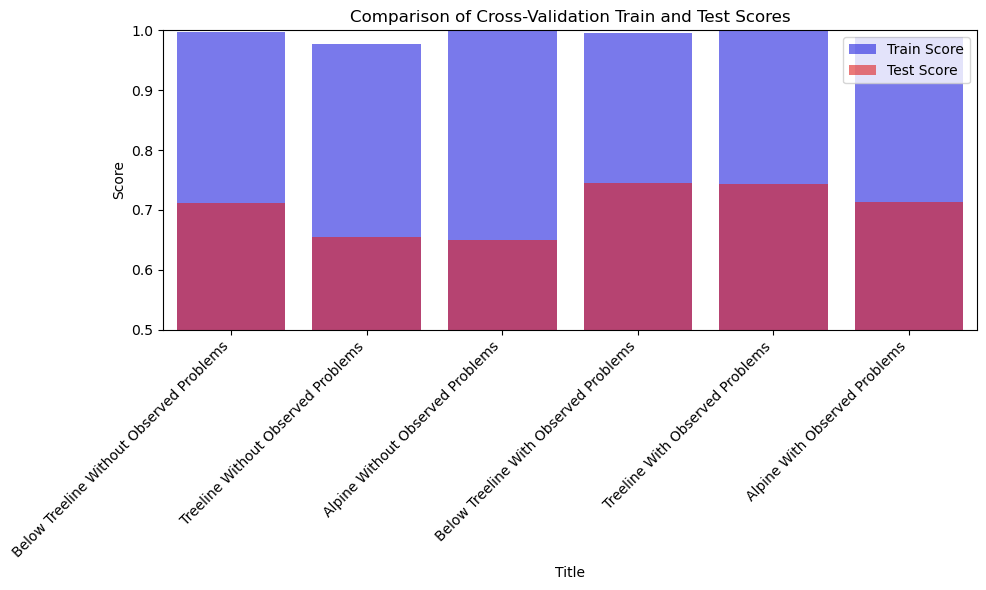

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Title', y='Best Cross-Validation Train Score', data=results_df, color='b', alpha=0.6, label='Train Score')
sns.barplot(x='Title', y='Best Cross-Validation Test Score', data=results_df, color='r', alpha=0.6, label='Test Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.title('Comparison of Cross-Validation Train and Test Scores')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

### Train scores were similar in all models, regardless of including the observed problems. For the test scores, the models that included observed problems were higher.

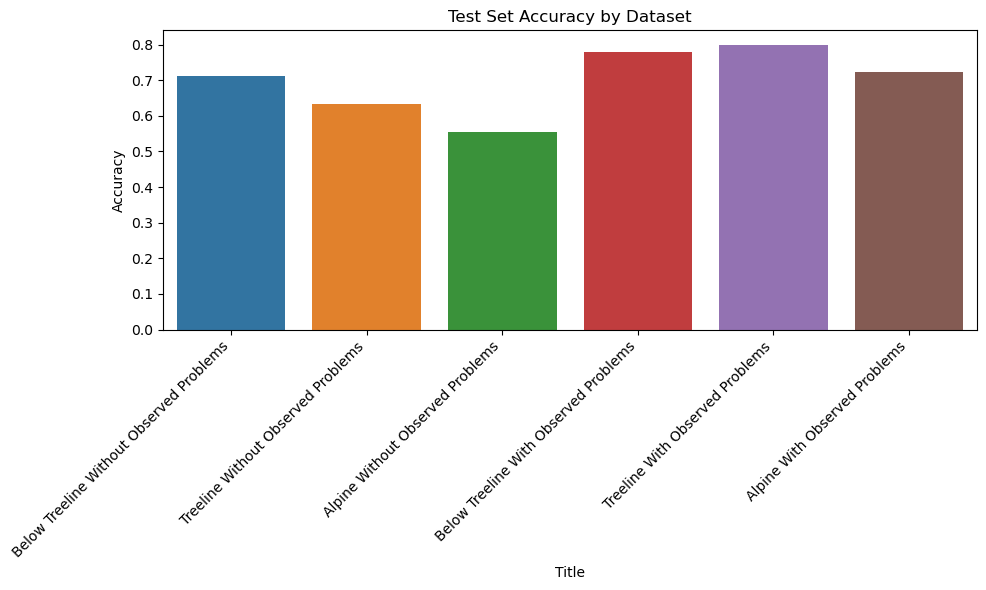

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Title', y='Test Set Accuracy', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('Test Set Accuracy by Dataset')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### Overall the models that accounted for the observed problems had a better accuracy.

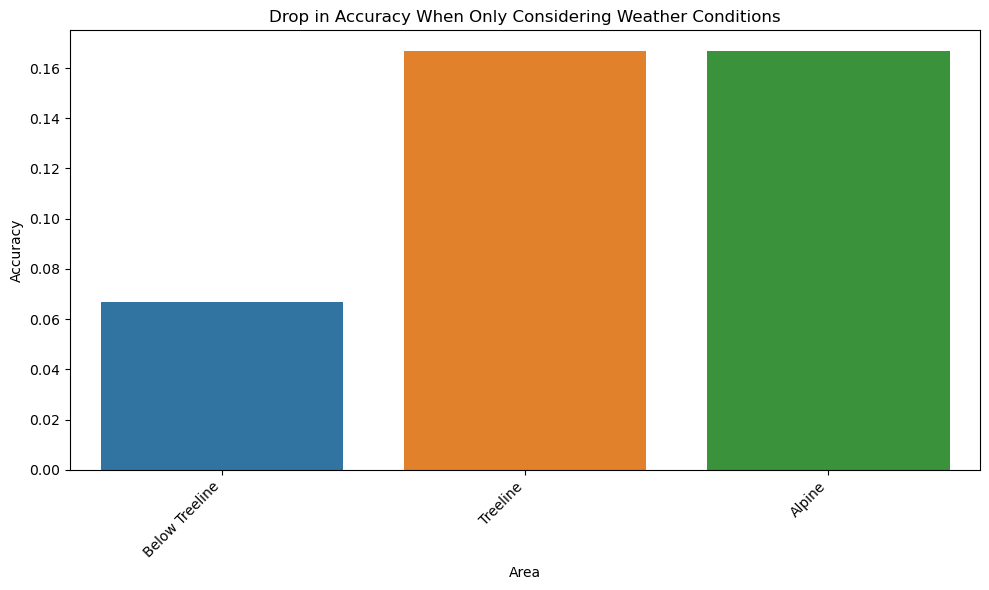

In [88]:
# Accuracy difference when including problems vs just weather data
blt_acc_delta = abs(results_df.loc[0,'Test Set Accuracy'] - results_df.loc[3, 'Test Set Accuracy'])
tln_acc_delta = abs(results_df.loc[1,'Test Set Accuracy'] - results_df.loc[4, 'Test Set Accuracy'])
alp_acc_delta = abs(results_df.loc[2,'Test Set Accuracy'] - results_df.loc[5, 'Test Set Accuracy'])

delta_df = pd.DataFrame({'Area':['Below Treeline', 'Treeline', 'Alpine'],
                         'Accuracy Drop': [blt_acc_delta, tln_acc_delta, alp_acc_delta]})

plt.figure(figsize=(10, 6))
sns.barplot(x='Area', y='Accuracy Drop', data=delta_df)
plt.xticks(rotation=45, ha='right')
plt.title('Drop in Accuracy When Only Considering Weather Conditions')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### Below the treeline, there is less of an impact from the observed problems. This jumps when in the treeline and above by almost 10%.

### ***Work below is an example of a confusion matrix and feature importance. Can apply this to all 6 models if we want***

In [14]:
# Instantiate best models
btl_exclude_problem_model = RandomForestClassifier(max_depth=15, n_estimators=800, random_state=0)
tln_exclude_problem_model = RandomForestClassifier(max_depth=15, n_estimators=400, random_state=0)
alp_exclude_problem_model = RandomForestClassifier(max_depth=13, n_estimators=400, random_state=0)
btl_include_problem_model = RandomForestClassifier(max_depth=15, n_estimators=800, random_state=0)
tln_include_problem_model = RandomForestClassifier(max_depth=15, n_estimators=400, random_state=0)
alp_include_problem_model = RandomForestClassifier(max_depth=13, n_estimators=400, random_state=0)

In [16]:
# Create feature matrices for including and excluding the observed problems. Encode necessary columns.
X_exclude_problem = X.drop(['problem_1', 'problem_2', 'problem_3'], axis=1)
X_exclude_problem = pd.get_dummies(X_exclude_problem, columns=['year', 'month', 'day'])

X_include_problem = X
X_include_problem = pd.get_dummies(X_include_problem, columns=['problem_1', 'problem_2', 'problem_3', 'year', 'month', 'day'])

In [18]:
# Test train split to fit each of the models
X_train_btl_exclude_problem, X_test_btl_exclude_problem, y_train_btl_exclude_problem, y_test_btl_exclude_problem = train_test_split(X_exclude_problem, y_btl, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_btl_exclude_problem = scaler.fit_transform(X_train_btl_exclude_problem)
X_test_btl_exclude_problem = scaler.transform(X_test_btl_exclude_problem)

X_train_tln_exclude_problem, X_test_tln_exclude_problem, y_train_tln_exclude_problem, y_test_tln_exclude_problem = train_test_split(X_exclude_problem, y_tln, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_tln_exclude_problem = scaler.fit_transform(X_train_tln_exclude_problem)
X_test_tln_exclude_problem = scaler.transform(X_test_tln_exclude_problem)

X_train_alp_exclude_problem, X_test_alp_exclude_problem, y_train_alp_exclude_problem, y_test_alp_exclude_problem = train_test_split(X_exclude_problem, y_alp, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_alp_exclude_problem = scaler.fit_transform(X_train_alp_exclude_problem)
X_test_alp_exclude_problem = scaler.transform(X_test_alp_exclude_problem)

X_train_btl_include_problem, X_test_btl_include_problem, y_train_btl_include_problem, y_test_btl_include_problem = train_test_split(X_include_problem, y_btl, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_btl_include_problem = scaler.fit_transform(X_train_btl_include_problem)
X_test_btl_include_problem = scaler.transform(X_test_btl_include_problem)

X_train_tln_include_problem, X_test_tln_include_problem, y_train_tln_include_problem, y_test_tln_include_problem = train_test_split(X_include_problem, y_tln, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_tln_include_problem = scaler.fit_transform(X_train_tln_include_problem)
X_test_tln_include_problem = scaler.transform(X_test_tln_include_problem)

X_train_alp_include_problem, X_test_alp_include_problem, y_train_alp_include_problem, y_test_alp_include_problem = train_test_split(X_include_problem, y_alp, test_size=0.1, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_alp_include_problem = scaler.fit_transform(X_train_alp_include_problem)
X_test_alp_include_problem = scaler.transform(X_test_alp_include_problem)

In [19]:
# Fit models
btl_exclude_problem_model.fit(X_train_btl_exclude_problem, y_train_btl_exclude_problem)
tln_exclude_problem_model.fit(X_train_tln_exclude_problem, y_train_tln_exclude_problem)
alp_exclude_problem_model.fit(X_train_alp_exclude_problem, y_train_alp_exclude_problem)
btl_include_problem_model.fit(X_train_btl_include_problem, y_train_btl_include_problem)
tln_include_problem_model.fit(X_train_tln_include_problem, y_train_tln_include_problem)
alp_include_problem_model.fit(X_train_alp_include_problem, y_train_alp_include_problem)

RandomForestClassifier(max_depth=13, n_estimators=400, random_state=0)

### Confusion Matrix

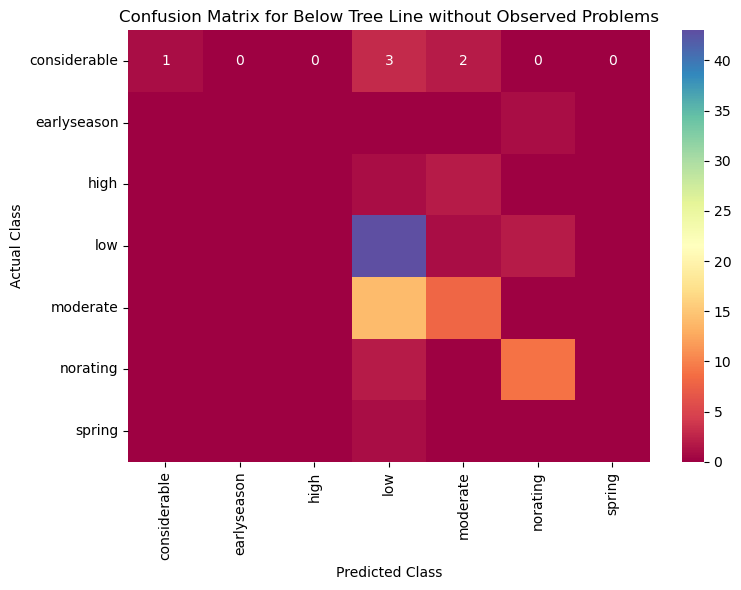

In [68]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y_test_btl_exclude_problem, y_pred=btl_exclude_problem_model.predict(X_test_btl_exclude_problem))

class_labels = ['considerable', 'earlyseason', 'high', 'low', 'moderate', 'norating', 'spring']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Spectral', xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for Below Tree Line without Observed Problems')
plt.tight_layout()
plt.show()

### Feature Importance

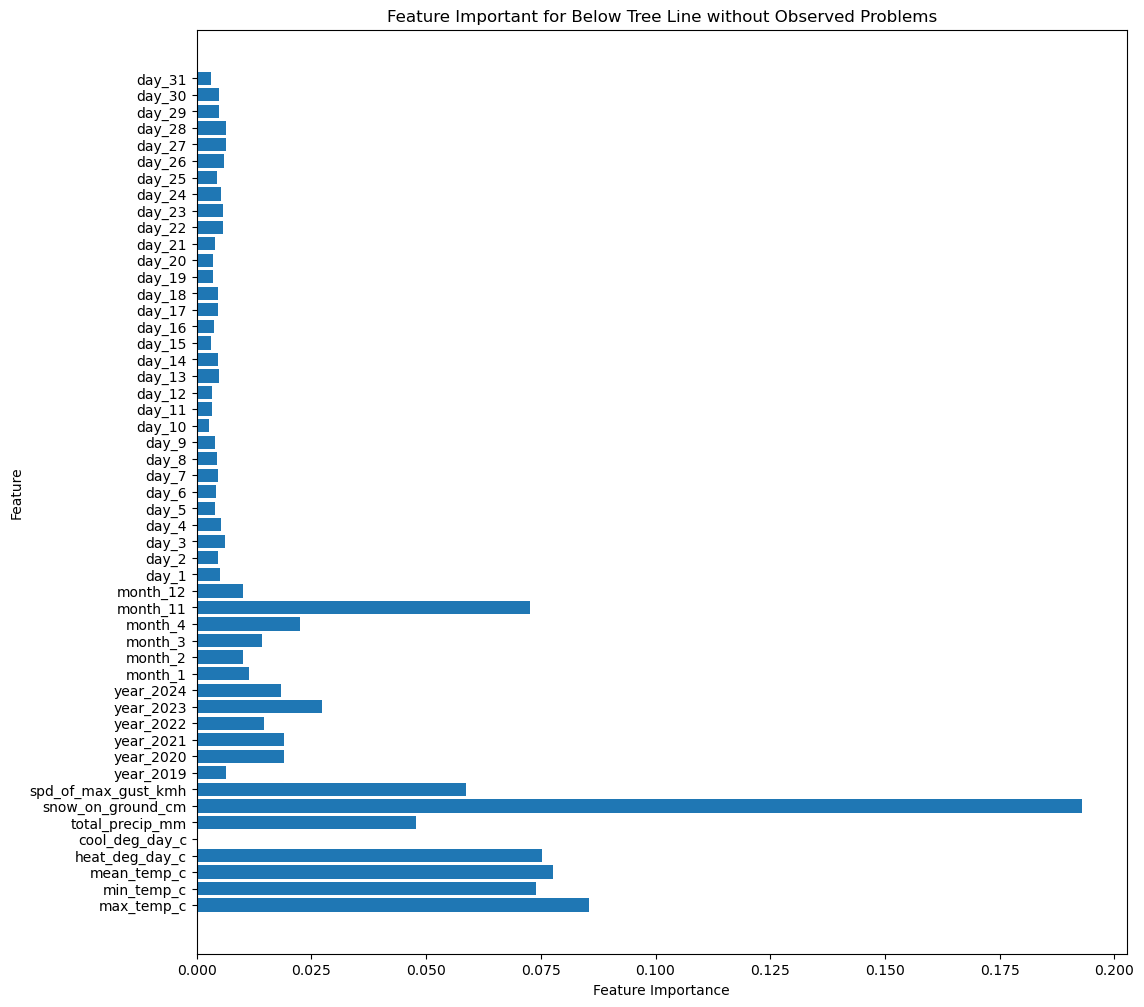

In [82]:
importances = btl_exclude_problem_model.feature_importances_
feature_names = X_exclude_problem.columns

plt.figure(figsize=(12,12))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Important for Below Tree Line without Observed Problems')
plt.show()